In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == 'cuda':
    print("✅ CUDA is available! GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA not available. Using CPU.")


Using device: cuda
✅ CUDA is available! GPU: NVIDIA GeForce RTX 2080 Ti


In [2]:
train_path = "cross_out_dataset/cross_out_dataset/train/images"
val_path   = "cross_out_dataset/cross_out_dataset/val/images"
test_path  = "cross_out_dataset/cross_out_dataset/test/images"


In [3]:
# ========================== STEP 1: Imports ==========================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

In [4]:
# ========================== STEP 2: Custom Dataset ==========================
class CrossOutBinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.clean_dir = os.path.join(root_dir, "CLEAN")
        self.cross_out_dirs = [
            "CROSS", "DIAGONAL", "DOUBLE_LINE",
            "SCRATCH", "SONGLE_LINE", "SINGLE_LINE", "WAVE", "ZIG_ZAG"
        ]
        self.transform = transform

        self.image_paths = []
        self.labels = []

        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

        for img_name in os.listdir(self.clean_dir):
            if os.path.splitext(img_name.lower())[1] in valid_extensions:
                self.image_paths.append(os.path.join(self.clean_dir, img_name))
                self.labels.append(0)

        for sub_dir in self.cross_out_dirs:
            full_path = os.path.join(root_dir, sub_dir)
            if not os.path.exists(full_path):
                continue
            for img_name in os.listdir(full_path):
                if os.path.splitext(img_name.lower())[1] in valid_extensions:
                    self.image_paths.append(os.path.join(full_path, img_name))
                    self.labels.append(1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert("RGB")
        except:
            image = Image.new("RGB", (128, 128))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32),image_path


In [5]:
# ========================== STEP 3: Paths and Transforms ==========================
train_path = "cross_out_dataset/cross_out_dataset/train/images"
val_path   = "cross_out_dataset/cross_out_dataset/val/images"
test_path  = "cross_out_dataset/cross_out_dataset/test/images"

train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.RandomRotation(15),  # Rotate images randomly by ±15 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping the image horizontally
    transforms.RandomVerticalFlip(p=0.2),  # 20% chance of flipping vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.6, 1.1)),  # Randomly shift the image
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.Resize((128, 128)),
    transforms.Pad(10),
    transforms.ToTensor()
])


val_test_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.Pad(10),
    transforms.ToTensor()
])

In [6]:
# ========================== STEP 4: Datasets and Loaders ==========================
train_dataset = CrossOutBinaryDataset(train_path, transform=train_transform)
val_dataset   = CrossOutBinaryDataset(val_path, transform=val_test_transform)
test_dataset  = CrossOutBinaryDataset(test_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
import os

print("✅ CLEAN exists in train set:", os.path.isdir(os.path.join(train_path, "CLEAN")))


✅ CLEAN exists in train set: True


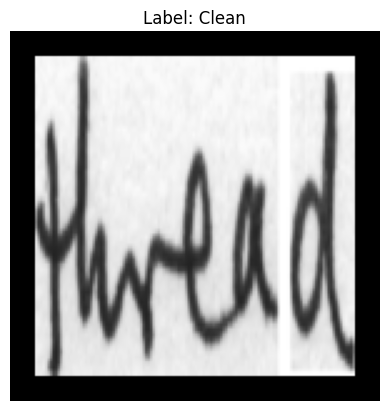

In [8]:
from matplotlib import pyplot as plt

sample_dataset = CrossOutBinaryDataset(train_path, transform=val_test_transform)
image, label, _ = sample_dataset[1]

plt.imshow(image.squeeze(0), cmap='gray')
plt.title("Label: " + ("Crossed-Out" if label == 1 else "Clean"))
plt.axis('off')
plt.show()


In [9]:
# ========================== STEP 5: ResNet18 Model ==========================
class CrossOutResNet(nn.Module):
    def __init__(self):
        super(CrossOutResNet, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

model = CrossOutResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
print(model)

CrossOutResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [11]:
from torchsummary import summary

summary(model, input_size=(1, 128, 128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [12]:
# ========================== STEP 6: Loss and Optimizer ==========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [13]:
# ========================== STEP 7: Train and Evaluate ==========================
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.unsqueeze(1).to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        num_batches = len(train_loader)
        print(f"\n[Epoch {epoch+1}/{epochs}] ➤ Processing {num_batches} batches...")

        for i, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / num_batches
        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader, device)

        print(f"[Epoch {epoch+1}] ✅ Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


In [14]:
# ========================== STEP 8: Test Evaluation ==========================
def test_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print(classification_report(y_true, y_pred, target_names=["Clean", "Crossed-Out"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap='Blues')
    plt.xticks([0,1], ["Clean", "Crossed-Out"])
    plt.yticks([0,1], ["Clean", "Crossed-Out"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


[Epoch 1/2] ➤ Processing 6111 batches...
[Epoch 1] ✅ Loss: 0.0842 | Train Acc: 96.85% | Val Acc: 97.52%

[Epoch 2/2] ➤ Processing 6111 batches...
[Epoch 2] ✅ Loss: 0.0613 | Train Acc: 97.78% | Val Acc: 96.94%
              precision    recall  f1-score   support

       Clean       0.95      0.87      0.90     25920
 Crossed-Out       0.98      0.99      0.98    142170

    accuracy                           0.97    168090
   macro avg       0.96      0.93      0.94    168090
weighted avg       0.97      0.97      0.97    168090



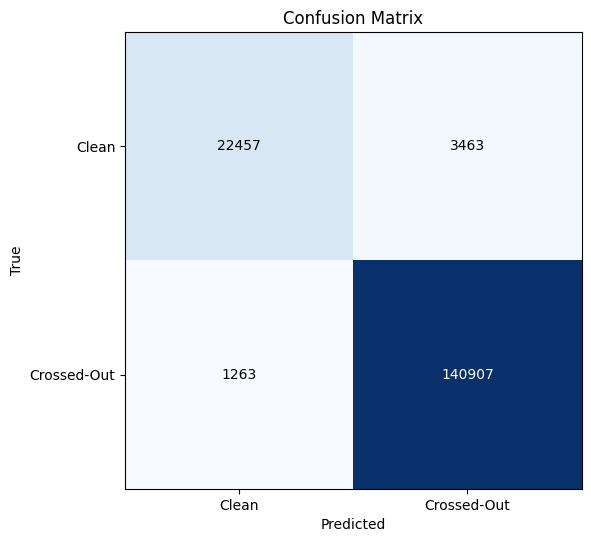

In [15]:
# ========================== STEP 9: Run Training and Testing ==========================
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=2)
torch.save(model.state_dict(), "crossed_out_resnet.pth")
test_model(model, test_loader, device)


Classification Report with Threshold  (0.50) :
              precision    recall  f1-score   support

       Clean       0.93      0.96      0.95        28
 Crossed-Out       0.96      0.92      0.94        24

    accuracy                           0.94        52
   macro avg       0.94      0.94      0.94        52
weighted avg       0.94      0.94      0.94        52


Visualizing up to 5 misclassified CLEAN samples:


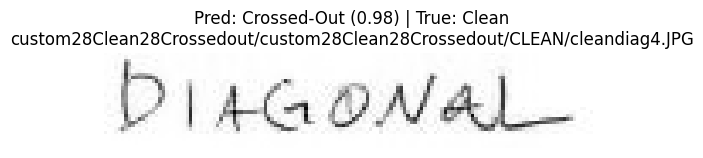

In [16]:
# ========================== STEP 10: Inference on Custom Unseen Images ==========================
custom_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Pad(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


custom_dataset = CrossOutBinaryDataset( "custom28Clean28Crossedout/custom28Clean28Crossedout/", transform=custom_transform)


custom_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

model.eval()
y_true, y_pred, image_paths, probs = [], [], [], []
threshold = 0.5
image_paths=[]

with torch.no_grad():
    for img, label, path in custom_loader:
        img = img.to(device)
        output = model(img)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > threshold else 0
        probs.append(prob)
        y_pred.append(pred)
        y_true.append(label.item())
        image_paths.append(path[0])

from sklearn.metrics import classification_report
print(f"\nClassification Report with Threshold  ({threshold:.2f}) :")
print(classification_report(y_true, y_pred, target_names=["Clean", "Crossed-Out"]))

# Visualize misclassified Clean examples
import matplotlib.pyplot as plt
from PIL import Image
print("\nVisualizing up to 5 misclassified CLEAN samples:")
shown = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and y_pred[i] == 1:
        img = Image.open(image_paths[i]).convert("L")
        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: Crossed-Out ({probs[i]:.2f}) | True: Clean\n{image_paths[i]}")
        plt.axis("off")
        shown += 1
        if shown == 5:
            break
plt.show()

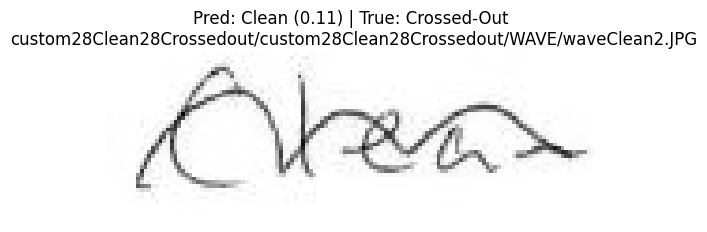

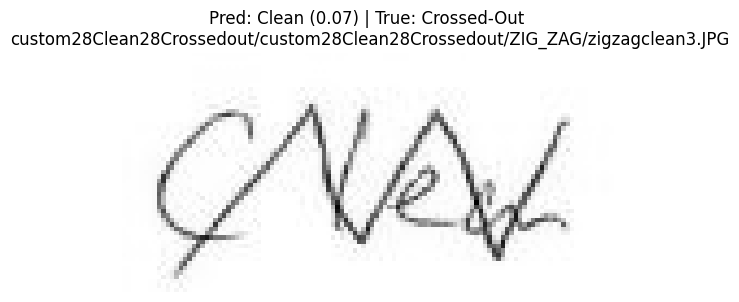

In [17]:
for i in range(len(y_true)):
    if y_true[i] == 1 and y_pred[i] == 0:
        img = Image.open(image_paths[i]).convert("L")
        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: Clean ({probs[i]:.2f}) | True: Crossed-Out \n{image_paths[i]}")
        plt.axis("off")
        shown += 1
        if shown == 5:
            break
plt.show()

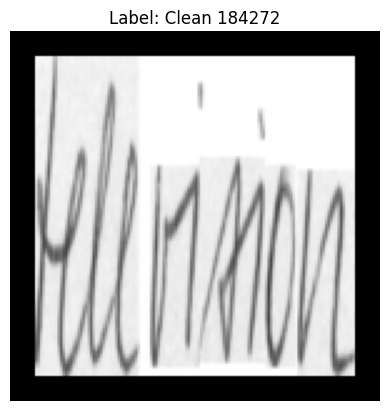

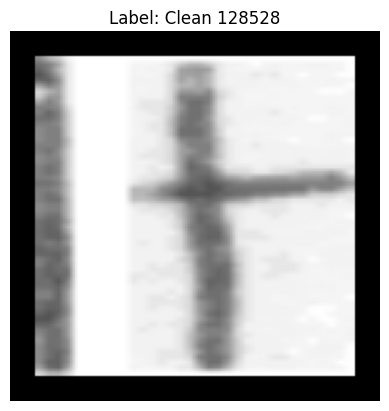

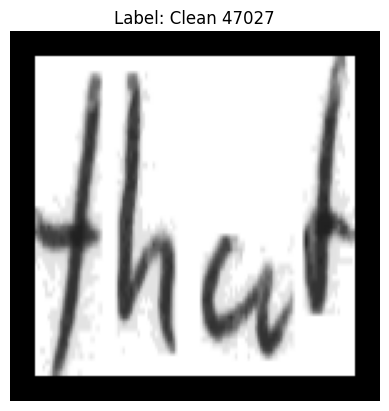

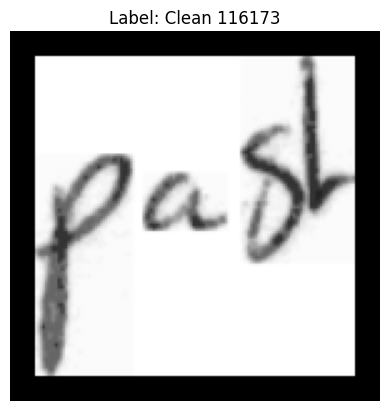

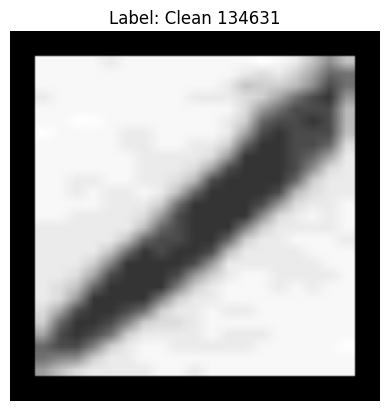

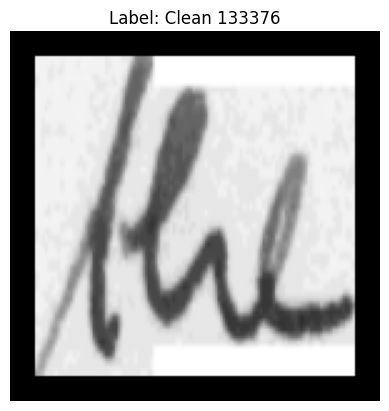

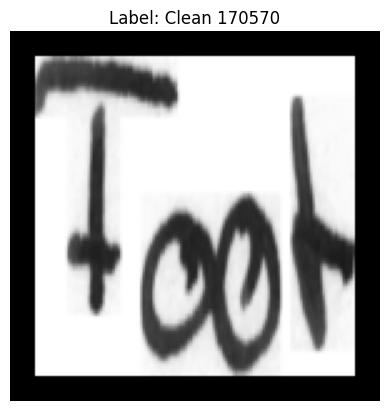

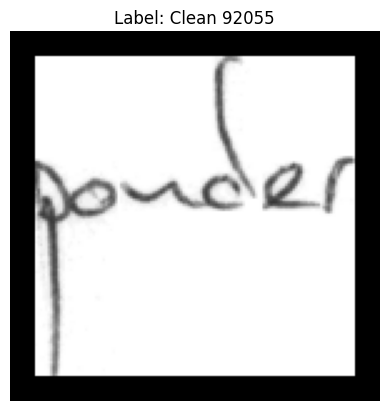

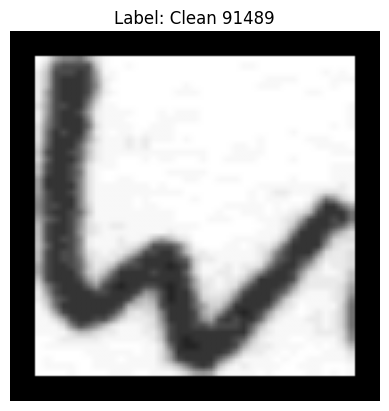

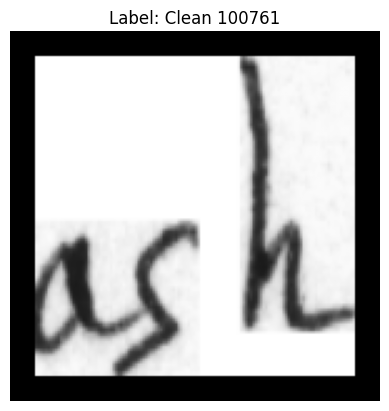

In [19]:
from matplotlib import pyplot as plt
import random
sample_dataset = CrossOutBinaryDataset(train_path, transform=val_test_transform)

for i in range(10):
    index=random.randint(1, 200000)
    image, label, _ = sample_dataset[random.randint(1, 50000)]
    
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title("Label: " + ("Crossed-Out" if label == 1 else "Clean") +" "+str(index))
    plt.axis('off')
    plt.show()
